In [ ]:
import os
HOME = os.getcwd()
print(HOME)
import numpy as np
import cv2

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.7/107.7 GB disk)


In [ ]:
!pip install supervision==0.18.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.18.0


In [ ]:
MODEL = "yolov8s.pt"

from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 21.5M/21.5M [00:00<00:00, 93.6MB/s]


YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


In [ ]:
SOURCE_VIDEO_PATH="/content/drive/MyDrive/Intent/traffic_video.mp4"

In [ ]:
tracker = sv.ByteTrack()

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]
final_selection={}
print(CLASS_NAMES_DICT)
for i in range(len(selected_classes)):
  final_selection[selected_classes[i]]=CLASS_NAMES_DICT[selected_classes[i]]
print(final_selection)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
# Define font and thickness for bold text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
thickness = 2

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=640, height=360, fps=30, total_frames=151)

In [ ]:
#Line 1:
LINE_START_1 = (160, 82)
LINE_END_1 = (81, 83)
LINE_START_anno_1 = sv.Point(169, 82)
LINE_END_anno_1 = sv.Point(81, 83)
#cv2.line(anotated_frame,LINE_START_1, LINE_END_1, color=(0, 255, 0), thickness=2)
line_zone1 = sv.LineZone(start=LINE_START_anno_1, end=LINE_END_anno_1)
#Line 2:
LINE_START_2 = (145, 109)
LINE_END_2 = (249, 108)
LINE_START_anno_2 = sv.Point(165, 109)
LINE_END_anno_2 = sv.Point(249, 108)
#cv2.line(anotated_frame,LINE_START_2, LINE_END_2, color=(255, 0, 0), thickness=2)
line_zone2 = sv.LineZone(start=LINE_START_anno_2, end=LINE_END_anno_2)
#Line 3:
LINE_START_3 = (264, 99)
LINE_END_3 = (338, 90)
LINE_START_anno_3 = sv.Point(264, 99)
LINE_END_anno_3 = sv.Point(338, 90)
#cv2.line(anotated_frame,LINE_START_3, LINE_END_3, color=(0, 255, 255), thickness=2)
line_zone3 = sv.LineZone(start=LINE_START_anno_3, end=LINE_END_anno_3)
#Line 4:
LINE_START_4 = (475, 154)
LINE_END_4 = (620, 218)
LINE_START_anno_4 = sv.Point(475, 154)
LINE_END_anno_4 = sv.Point(602, 218)
#cv2.line(anotated_frame,LINE_START_4, LINE_END_4, color=(255, 0, 255), thickness=2)
line_zone4 = sv.LineZone(start=LINE_START_anno_4, end=LINE_END_anno_4)
line_zones={1: line_zone1, 2: line_zone2, 3: line_zone3, 4: line_zone4}

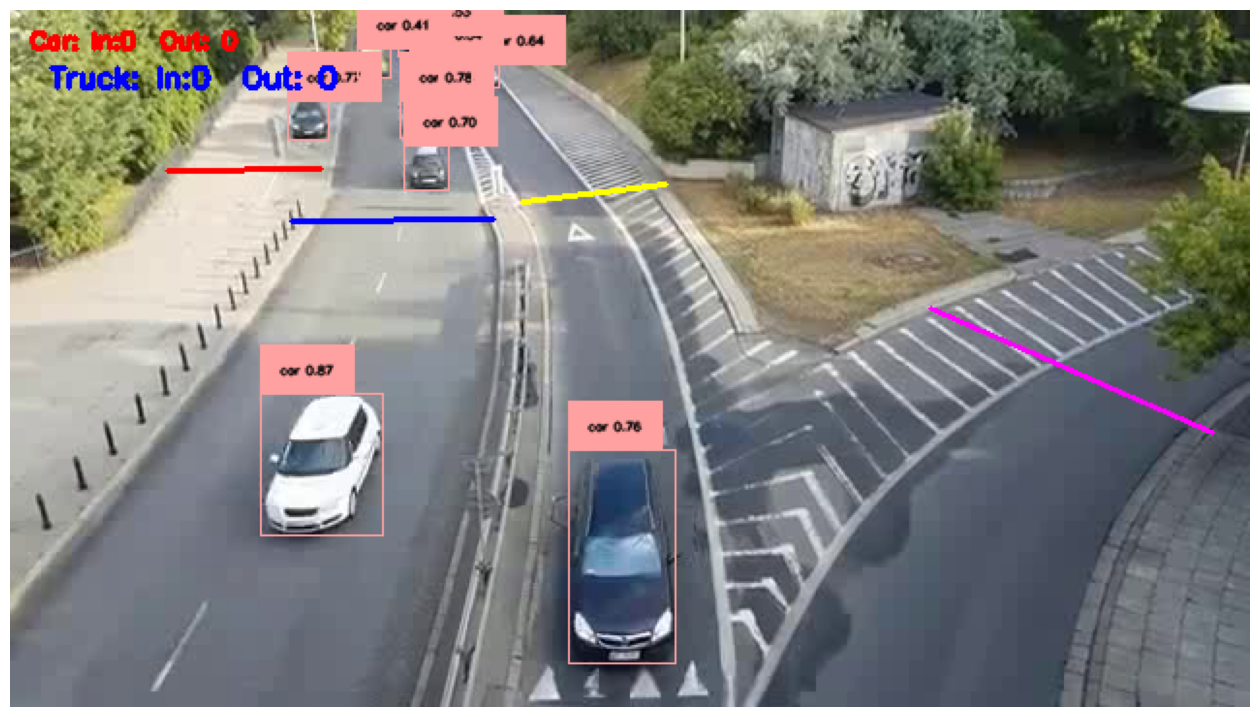

In [ ]:
final_selection = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
count_in = {key: 0 for key in final_selection.keys()}
count_out = {key: 0 for key in final_selection.keys()}

bus_index=5
car_index=2
truck_index=7
motorcycle_index=3

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=.2)
# acquire first video frame
iterator = iter(frames_generator)
frame = next(frames_generator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
#print("First_Detection: ",detections)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]
#print("After_isin_Detection: ",detections)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)
#Draw a simple green line
LINE_START = (50, 50)
LINE_END = (400, 280)
# cv2.line(anotated_frame, LINE_START, LINE_END, color=(255, 255, 0), thickness=10)
cv2.line(anotated_frame,LINE_START_2, LINE_END_2, color=(255, 0, 0), thickness=2)
cv2.line(anotated_frame,LINE_START_3, LINE_END_3, color=(0, 255, 255), thickness=2)
cv2.line(anotated_frame,LINE_START_4, LINE_END_4, color=(255, 0, 255), thickness=2)
cv2.line(anotated_frame,LINE_START_1, LINE_END_1, color=(0, 0, 255), thickness=2)

# cv2.rectangle(anotated_frame, rect_top_left, rect_bottom_right, rect_color, 0)
# cv2.rectangle(anotated_frame, rect_top_left2, rect_bottom_right2, rect_color2, 0)
# cv2.rectangle(anotated_frame, rect_top_left3, rect_bottom_right3, rect_color3, 0)
# cv2.rectangle(anotated_frame, rect_top_left4, rect_bottom_right4, rect_color4, 0)


cv2.putText(anotated_frame, f"Car: In:{count_in[car_index]}  Out: {count_out[car_index]}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 2)
cv2.putText(anotated_frame, f"Truck: In:{count_in[truck_index]}  Out: {count_out[truck_index]}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
cv2.putText(anotated_frame, f"MotorCycle: In:{count_in[motorcycle_index]}  Out: {count_out[motorcycle_index]}", (1100-50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
cv2.putText(anotated_frame, f"Bus: In:{count_in[bus_index]}  Out: {count_out[bus_index]}", (1100-50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)


%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

In [ ]:
number_of_lanes=4
count_in = {key: 0 for key in final_selection.keys()}
count_out = {key: 0 for key in final_selection.keys()}


lanes_dict = {
    lane: {
        'count_in': count_in.copy(),
        'count_out': count_out.copy()
    }
    for lane in range(1,number_of_lanes + 1)
}
lanes_dict

{1: {'count_in': {2: 0, 3: 0, 5: 0, 7: 0},
  'count_out': {2: 0, 3: 0, 5: 0, 7: 0}},
 2: {'count_in': {2: 0, 3: 0, 5: 0, 7: 0},
  'count_out': {2: 0, 3: 0, 5: 0, 7: 0}},
 3: {'count_in': {2: 0, 3: 0, 5: 0, 7: 0},
  'count_out': {2: 0, 3: 0, 5: 0, 7: 0}},
 4: {'count_in': {2: 0, 3: 0, 5: 0, 7: 0},
  'count_out': {2: 0, 3: 0, 5: 0, 7: 0}}}

In [ ]:
colors_code = [
    (0, 0, 255),   # Red
    (0, 255, 0),   # Green
    (255, 0, 0),   # Blue
    (0, 255, 255), # Yellow
    (255, 0, 255)  # Magenta
]


rect_top_left1 = (11, 15)  # Top-left corner of the rectangle (x, y)
rect_bottom_right1 = (82, 118)  # Bottom-right corner of the rectangle (x, y)
rect_color1 = colors_code[0]
rect_thickness = -1  # Thickness of the rectangle

rect_top_left2 = (455, 15)   # Top-left corner of the rectangle (x, y)
rect_bottom_right2 = (510, 96)  # Bottom-right corner of the rectangle (x, y)
rect_color2 = colors_code[1]
rect_thickness2 = 2  # Thickness of the rectangle

rect_top_left3 = (360, 14)  # Top-left corner of the rectangle (x, y)
rect_bottom_right3 = (450, 95)   # Bottom-right corner of the rectangle (x, y)
rect_color3 = colors_code[2]
rect_thickness3 = 2  # Thickness of the rectangle

rect_top_left4 = (548, 267)  # Top-left corner of the rectangle (x, y)
rect_bottom_right4 = (630, 349)  # Bottom-right corner of the rectangle (x, y)
rect_color4 = colors_code[3]
rect_thickness4 = 2  # Thickness of the rectangle

vehicle_types=["Car","Bus","Truck","MotorCycle"]
num_rows = len(vehicle_types)

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.4  # Small font scale
text_color = (255, 255, 0)  # White text
text_thickness = 2



border_rectangle_finder = {
    i: (
        globals().get(f'rect_top_left{i+1}', None),
        globals().get(f'rect_bottom_right{i+1}', None),
        globals().get(f'rect_color{i+1}', None)
    ) for i in range(number_of_lanes)
}

In [ ]:

for x in range(number_of_lanes):
          top_left, boottom_right,color_rect = border_rectangle_finder[x]
          row_height = (boottom_right[1] - top_left[1]) // num_rows


25
20
20
20


In [ ]:
Target_Video_path="/content/traffic_video45.mp4"

In [ ]:
from tqdm.notebook import tqdm

LINE_START = sv.Point(20, 500)
LINE_END = sv.Point(1280, 500)
LINE_START_cv2 = (20, 500)
LINE_END_cv2 = (1280, 500)

final_selection = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
bus_index=5
car_index=2
truck_index=7
motorcycle_index=3

# Initialize count dictionaries
number_of_lanes=4
count_in = {key: 0 for key in final_selection.keys()}
count_out = {key: 0 for key in final_selection.keys()}


lanes_dict = {
    lane: {
        'count_in': count_in.copy(),
        'count_out': count_out.copy()
    }
    for lane in range(0,number_of_lanes)
}

# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=.5)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=0, trace_length=0)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=1, text_scale=1)


line_zones = {
    i: globals().get(f'line_zone{i+1}', None) for i in range(number_of_lanes)
}


# open target video file
with sv.VideoSink(Target_Video_path, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        # only consider class id from selected_classes define above
        detections = detections[np.isin(detections.class_id, selected_classes)]
        # tracking detections
        detections = byte_tracker.update_with_detections(detections)
        labels = [
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
            for confidence, class_id, tracker_id
            in zip(detections.confidence, detections.class_id, detections.tracker_id)
        ]
        annotated_frame = trace_annotator.annotate(
            scene=frame.copy(),
            detections=detections
        )
        annotated_frame=box_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels)

        # update line counter
        crossed_in_dict = {}
        crossed_out_dict = {}
        detection_class_id = detections.class_id

        for i in range(number_of_lanes):
          line_zone = line_zones.get(i)
          crossed_in, crossed_out = line_zone.trigger(detections)
          crossed_in_dict[f'crossed_in_{i}'] = crossed_in
          crossed_out_dict[f'crossed_out_{i}'] = crossed_out

          for j in range(len(detection_class_id)):
            class_id = detection_class_id[j]
            if crossed_in[j]:
                if class_id in count_in:
                    #crossed_in_dict[f'crossed_in_{i}'][class_id]+= 1
                    #count_in[class_id] += 1
                    lanes_dict[i]["count_in"][class_id]+=1
            if crossed_out[j]:
                if class_id in count_out:
                  #crossed_in_dict[f'crossed_out_{i}'][class_id]+= 1
                  #count_out[class_id] += 1
                  lanes_dict[i]["count_out"][class_id]+=1

        # print(crossed_in_dict)
        # print(crossed_out_dict)
        # print(lanes_dict)

        # crossed_in, crossed_out = line_zone.trigger(detections)
        # detection_class_id = detections.class_id
        # # Update counts based on crossed_in and crossed_out
        # for i in range(len(detection_class_id)):
        #     class_id = detection_class_id[i]
        #     if crossed_in[i]:
        #         if class_id in count_in:
        #             count_in[class_id] += 1
        #     if crossed_out[i]:
        #         if class_id in count_out:
        #           count_out[class_id] += 1


        cv2.line(annotated_frame,LINE_START_2, LINE_END_2, color=(255, 0, 0), thickness=2)
        cv2.line(annotated_frame,LINE_START_3, LINE_END_3, color=(0, 255, 255), thickness=2)
        cv2.line(annotated_frame,LINE_START_4, LINE_END_4, color=(255, 0, 255), thickness=2)
        cv2.line(annotated_frame,LINE_START_1, LINE_END_1, color=(0, 0, 255), thickness=2)

        # cv2.rectangle(anotated_frame, rect_top_left, rect_bottom_right, rect_color, 0)
        # cv2.rectangle(anotated_frame, rect_top_left2, rect_bottom_right2, rect_color2, 0)
        # cv2.rectangle(anotated_frame, rect_top_left3, rect_bottom_right3, rect_color3, 0)
        # cv2.rectangle(anotated_frame, rect_top_left4, rect_bottom_right4, rect_color4, 0)

        for x in range(number_of_lanes):
          top_left, boottom_right,color_rect = border_rectangle_finder[x]
          cv2.rectangle(annotated_frame, top_left, boottom_right, color_rect, 0)
          row_height = (boottom_right[1] - top_left[1]) // num_rows

          i=0
          text = vehicle_types[i]
          text_x = top_left[0] + 2  # Slightly inside the rectangle
          text_y = top_left[1] + (i + 1) * row_height - 10  # Adjust to fit inside row
          cv2.putText(annotated_frame, f"Car: {lanes_dict[x]['count_in'][car_index]}",  (text_x, text_y), font, fontScale, text_color, text_thickness, cv2.LINE_AA)
          print(f"Car: {lanes_dict[x]['count_in'][car_index]}")
          i+=1
          text_y = top_left[1] + (i + 1) * row_height - 10  # Adjust to fit inside row
          i+=1
          cv2.putText(annotated_frame, f"Truck: {lanes_dict[x]['count_in'][truck_index]}",  (text_x, text_y), font, fontScale, text_color, text_thickness, cv2.LINE_AA)
          text_y = top_left[1] + (i + 1) * row_height - 10  # Adjust to fit inside row
          i+=1
          cv2.putText(annotated_frame, f"MotorCycle: {lanes_dict[x]['count_in'][motorcycle_index]}",  (text_x, text_y), font, fontScale, text_color, text_thickness, cv2.LINE_AA)
          text_y = top_left[1] + (i + 1) * row_height - 10  # Adjust to fit inside row
          i+=1
          cv2.putText(annotated_frame, f"Bus: {lanes_dict[x]['count_in'][bus_index]}",  (text_x, text_y), font, fontScale, text_color, text_thickness, cv2.LINE_AA)
          text_y = top_left[1] + (i + 1) * row_height - 10  # Adjust to fit inside row



        # print(lanes_dict)
        # cv2.putText(annotated_frame, f"Car: In:{count_in[car_index]}  Out: {count_out[car_index]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        # cv2.putText(annotated_frame, f"Truck: In:{count_in[truck_index]}  Out: {count_out[truck_index]}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        # cv2.putText(annotated_frame, f"MotorCycle: In:{count_in[motorcycle_index]}  Out: {count_out[motorcycle_index]}", (1100-50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        # cv2.putText(annotated_frame, f"Bus: In:{count_in[bus_index]}  Out: {count_out[bus_index]}", (1100-50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        sink.write_frame(annotated_frame)

  0%|          | 0/151 [00:00<?, ?it/s]

Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0
Car: 0
Car: 0
Car: 1
Car: 0

In [ ]:
Target_Video_path="/content/traffic_video45.mp4"

In [ ]:
from tqdm.notebook import tqdm

LINE_START = sv.Point(20, 500)
LINE_END = sv.Point(1280, 500)
LINE_START_cv2 = (20, 500)
LINE_END_cv2 = (1280, 500)

final_selection = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
bus_index=5
car_index=2
truck_index=7
motorcycle_index=3

# Initialize count dictionaries
count_in = {key: 0 for key in final_selection.keys()}
count_out = {key: 0 for key in final_selection.keys()}

# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=.5)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=0, trace_length=0)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=1, text_scale=1)

# open target video file
with sv.VideoSink(Target_Video_path, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame, verbose=True)[0]
        detections = sv.Detections.from_ultralytics(results)
        # only consider class id from selected_classes define above
        detections = detections[np.isin(detections.class_id, selected_classes)]
        # tracking detections
        detections = byte_tracker.update_with_detections(detections)
        labels = [
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
            for confidence, class_id, tracker_id
            in zip(detections.confidence, detections.class_id, detections.tracker_id)
        ]
        annotated_frame = trace_annotator.annotate(
            scene=frame.copy(),
            detections=detections
        )
        annotated_frame=box_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels)

        # update line counter
        crossed_in, crossed_out = line_zone.trigger(detections)
        detection_class_id = detections.class_id
        # Update counts based on crossed_in and crossed_out
        for i in range(len(detection_class_id)):
            class_id = detection_class_id[i]
            if crossed_in[i]:
                if class_id in count_in:
                    count_in[class_id] += 1
            if crossed_out[i]:
                if class_id in count_out:
                  count_out[class_id] += 1

        cv2.line(annotated_frame, LINE_START_cv2, LINE_END_cv2, color=(255, 0, 0), thickness=2)
        cv2.putText(annotated_frame, f"Car: In:{count_in[car_index]}  Out: {count_out[car_index]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(annotated_frame, f"Truck: In:{count_in[truck_index]}  Out: {count_out[truck_index]}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        cv2.putText(annotated_frame, f"MotorCycle: In:{count_in[motorcycle_index]}  Out: {count_out[motorcycle_index]}", (1100-50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(annotated_frame, f"Bus: In:{count_in[bus_index]}  Out: {count_out[bus_index]}", (1100-50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        sink.write_frame(annotated_frame)

  0%|          | 0/151 [00:00<?, ?it/s]


0: 384x640 9 cars, 1 train, 385.8ms
Speed: 5.2ms preprocess, 385.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 415.8ms
Speed: 6.3ms preprocess, 415.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 404.6ms
Speed: 5.9ms preprocess, 404.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 frisbee, 398.1ms
Speed: 8.0ms preprocess, 398.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 frisbee, 398.2ms
Speed: 6.2ms preprocess, 398.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 frisbee, 398.7ms
Speed: 3.9ms preprocess, 398.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 frisbee, 383.2ms
Speed: 5.2ms preprocess, 383.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 frisbee, 402.7ms
Speed: 5.2ms prepro

In [ ]:
# SOURCE_VIDEO_PATH="/content/traffic_video.mp4"
# Target_Video_path="/content/traffic_video1.mp4"


# LINE_START = sv.Point(20, 500)
# LINE_END = sv.Point(1280, 500)
# LINE_START_cv2 = (20, 500)
# LINE_END_cv2 = (1280, 500)


# final_selection = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
# bus_index=5
# car_index=2
# truck_index=7
# motorcycle_index=3

# # Initialize count dictionaries
# count_in = {key: 0 for key in final_selection.keys()}
# count_out = {key: 0 for key in final_selection.keys()}
# def callback(frame: np.ndarray, index:int) -> np.ndarray:
#     # model prediction on single frame and conversion to supervision Detections
#     results = model(frame, verbose=False)[0]
#     detections = sv.Detections.from_ultralytics(results)
#     # only consider class id from selected_classes define above
#     detections = detections[np.isin(detections.class_id, selected_classes)]
#     # tracking detections
#     detections = byte_tracker.update_with_detections(detections)
#     labels = [
#         f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
#         for confidence, class_id, tracker_id
#         in zip(detections.confidence, detections.class_id, detections.tracker_id)
#     ]
#     annotated_frame = trace_annotator.annotate(
#         scene=frame.copy(),
#         detections=detections
#     )
#     annotated_frame=box_annotator.annotate(
#         scene=annotated_frame,
#         detections=detections,
#         labels=labels)

#     # update line counter
#     crossed_in, crossed_out = line_zone.trigger(detections)
#     detection_class_id = detections.class_id
#     # Update counts based on crossed_in and crossed_out
#     for i in range(len(detection_class_id)):
#         class_id = detection_class_id[i]
#         if crossed_in[i]:
#             if class_id in count_in:
#                 count_in[class_id] += 1
#         if crossed_out[i]:
#             if class_id in count_out:
#               count_out[class_id] += 1

#     cv2.line(annotated_frame, LINE_START_cv2, LINE_END_cv2, color=(255, 0, 0), thickness=2)
#     cv2.putText(annotated_frame, f"Car: In:{count_in[car_index]}  Out: {count_out[car_index]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
#     cv2.putText(annotated_frame, f"Truck: In:{count_in[truck_index]}  Out: {count_out[truck_index]}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
#     cv2.putText(annotated_frame, f"MotorCycle: In:{count_in[motorcycle_index]}  Out: {count_out[motorcycle_index]}", (1100-50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
#     cv2.putText(annotated_frame, f"Bus: In:{count_in[bus_index]}  Out: {count_out[bus_index]}", (1100-50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

#     return  annotated_frame

# # process the whole video
# sv.process_video(
#     source_path = SOURCE_VIDEO_PATH,
#     target_path = Target_Video_path,
#     callback=callback
# )